In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [4]:
!wget -O dataset.zip 'https://www.dropbox.com/scl/fi/oflwyz93fvnia19bjt0ev/dataset.zip?rlkey=vetkn3ujxud07z3q1bbdpog6a&dl=0'

--2024-03-09 10:47:54--  https://www.dropbox.com/scl/fi/oflwyz93fvnia19bjt0ev/dataset.zip?rlkey=vetkn3ujxud07z3q1bbdpog6a&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1552b05ee65eb188010da00e52.dl.dropboxusercontent.com/cd/0/inline/COykJjsabEt4ny30VzD_kO0ubR6UqMBNKmHfLknOX-aSnZeYgJftHjVL4zekHhIZM8wNt5yrodSnC7ZwTnSYU8WHqY1Lo16CKF8hMLEh-wEBVaH6ecXI3SkNUYtcIVzvCcsLZAMFZtDihDfyNyiJMD9G/file# [following]
--2024-03-09 10:47:55--  https://uc1552b05ee65eb188010da00e52.dl.dropboxusercontent.com/cd/0/inline/COykJjsabEt4ny30VzD_kO0ubR6UqMBNKmHfLknOX-aSnZeYgJftHjVL4zekHhIZM8wNt5yrodSnC7ZwTnSYU8WHqY1Lo16CKF8hMLEh-wEBVaH6ecXI3SkNUYtcIVzvCcsLZAMFZtDihDfyNyiJMD9G/file
Resolving uc1552b05ee65eb188010da00e52.dl.dropboxusercontent.com (uc1552b05ee65eb188010da00e52.dl.dropboxusercontent.com)... 162.125.3.15, 26

In [5]:
!unzip -o -qq dataset.zip -d /kaggle/working/

In [6]:
data = "/kaggle/working/dataset/H"
len(os.listdir(data))

3000

In [7]:
import os
import random
import shutil

def create_split(source_folder, destination_folder, train_percent=0.7, val_percent=0.15, test_percent=0.15):
    # Create train, val, test folders
    train_folder = os.path.join(destination_folder, 'train')
    val_folder = os.path.join(destination_folder, 'val')
    test_folder = os.path.join(destination_folder, 'test')

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Iterate through each class folder (A-Z and nothing)
    for class_folder in os.listdir(source_folder):
        class_path = os.path.join(source_folder, class_folder)
        os.makedirs(os.path.join(train_folder,class_folder), exist_ok=True)
        os.makedirs(os.path.join(val_folder,class_folder), exist_ok=True)
        os.makedirs(os.path.join(test_folder,class_folder), exist_ok=True)

        if os.path.isdir(class_path):
            # List all files in the class folder
            files = os.listdir(class_path)
            random.shuffle(files)

            # Calculate the number of files for each split
            total_files = len(files)
            train_count = int(train_percent * total_files)
            val_count = int(val_percent * total_files)

            # Split the files into train, val, and test
            train_files = files[:train_count]
            val_files = files[train_count:train_count + val_count]
            test_files = files[train_count + val_count:]

            # Move files to respective split folders
            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_folder, class_folder))

            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_folder, class_folder))

            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_folder, class_folder))

# Example usage
source_dataset_folder = '/kaggle/working/dataset'
destination_split_folder = '/kaggle/working/new_data'

create_split(source_dataset_folder, destination_split_folder)


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False
)

batch_size = 32
image_height = 224
image_width = 224

train =  "/kaggle/working/new_data/train"
validation =  "/kaggle/working/new_data/val"
test =  "/kaggle/working/new_data/test"

train_generator = datagen.flow_from_directory(
    train,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True
)

validation_generator = datagen.flow_from_directory(
    validation,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True
)

test_generator = datagen.flow_from_directory(
    test,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)


2024-03-09 10:48:40.638938: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 10:48:40.638990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 10:48:40.640634: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 79196 images belonging to 29 classes.
Found 24121 images belonging to 29 classes.
Found 24118 images belonging to 29 classes.


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, AveragePooling2D, Flatten, Dense

def identity_block(X, f, filters):
    F1, F2 = filters

    X_shortcut = X

    # First layer
    X = Conv2D(filters=F1, kernel_size=(f, f), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second layer
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)

    # Add shortcut value to main path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, s=2):
    F1, F2 = filters

    X_shortcut = X

    # First layer
    X = Conv2D(filters=F1, kernel_size=(f, f), strides=(s, s), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second layer
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)

    # Shortcut path
    X_shortcut = Conv2D(filters=F2, kernel_size=(f, f), strides=(s, s), padding='same')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # Add shortcut value to main path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def ResNet18(input_shape=(224, 224, 3), classes=1000):
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64], s=1)
    X = identity_block(X, 3, [64, 64])
    X = identity_block(X, 3, [64, 64])

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128], s=2)
    X = identity_block(X, 3, [128, 128])
    X = identity_block(X, 3, [128, 128])

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256], s=2)
    X = identity_block(X, 3, [256, 256])
    X = identity_block(X, 3, [256, 256])

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512], s=2)
    X = identity_block(X, 3, [512, 512])
    X = identity_block(X, 3, [512, 512])

    # Average pooling
    X = AveragePooling2D((4, 4))(X)

    # Flatten
    X = Flatten()(X)

    # Fully connected layer
    X = Dense(classes, activation='softmax')(X)

    model = tf.keras.Model(inputs=X_input, outputs=X, name='ResNet18')

    return model

# Example usage:
input_shape = (224, 224, 3)
num_classes = 29  # Change this based on your specific problem
model = ResNet18(input_shape, num_classes)

# Print model summary
model.summary()


Model: "ResNet18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 18,895,709 (72.08 MB)

 Trainable params: 18,882,141 (72.03 MB)

 Non-trainable params: 13,568 (53.00 KB)

In [10]:
import tensorflow as tf

lr0 = 0.001

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="loss",
        min_delta=1e-2,
        patience=15,
        verbose=1,
        restore_best_weights=True
    )]

model.compile(optimizer=tf.keras.optimizers.Adam(lr0),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator)//32,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)//32,
    callbacks = callbacks)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1709981442.221189     278 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


77/77 ━━━━━━━━━━━━━━━━━━━━ 79s 536ms/step - accuracy: 0.0562 - loss: 3.9347 - val_accuracy: 0.0285 - val_loss: 8.8449
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 38s 492ms/step - accuracy: 0.1206 - loss: 3.0045 - val_accuracy: 0.0326 - val_loss: 29.7211
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 36s 477ms/step - accuracy: 0.2281 - loss: 2.5371 - val_accuracy: 0.1535 - val_loss: 3.3913
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 34s 444ms/step - accuracy: 0.3874 - loss: 1.9772 - val_accuracy: 0.3519 - val_loss: 2.0914
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 372ms/step - accuracy: 0.5338 - loss: 1.4317 - val_accuracy: 0.0421 - val_loss: 14.0688
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 30s 391ms/step - accuracy: 0.6844 - loss: 0.9461 - val_accuracy: 0.1467 - val_loss: 24.7849
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 415ms/step - accuracy: 0.7675 - loss: 0.6750 - val_accuracy: 0.2364 - val_loss: 10.8904
Epoch 8/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 404ms/step - accuracy: 0.7987 - loss: 0.5863 - val_accu

W0000 00:00:1709982004.213894     279 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 47s 614ms/step - accuracy: 0.9359 - loss: 0.2073 - val_accuracy: 0.5258 - val_loss: 3.2809
Epoch 18/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 341ms/step - accuracy: 0.9542 - loss: 0.1466 - val_accuracy: 0.6916 - val_loss: 1.5022
Epoch 19/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 30s 397ms/step - accuracy: 0.9610 - loss: 0.1289 - val_accuracy: 0.8682 - val_loss: 0.4197
Epoch 20/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 404ms/step - accuracy: 0.9449 - loss: 0.1798 - val_accuracy: 0.5068 - val_loss: 2.9332
Epoch 21/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 403ms/step - accuracy: 0.9487 - loss: 0.1582 - val_accuracy: 0.8315 - val_loss: 0.6642
Epoch 22/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 410ms/step - accuracy: 0.9532 - loss: 0.1358 - val_accuracy: 0.6916 - val_loss: 1.6860
Epoch 23/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 401ms/step - accuracy: 0.9639 - loss: 0.1130 - val_accuracy: 0.5530 - val_loss: 2.2005
Epoch 24/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 407ms/step - accuracy: 0.9672 - loss: 0.1010 - val_a

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9586 - loss: 0.0987 - val_accuracy: 0.8489 - val_loss: 0.5068
Epoch 34/100


W0000 00:00:1709982468.418836     277 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 41s 495ms/step - accuracy: 0.9834 - loss: 0.0595 - val_accuracy: 0.8288 - val_loss: 0.8728
Epoch 35/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 480ms/step - accuracy: 0.9771 - loss: 0.0697 - val_accuracy: 0.9130 - val_loss: 0.2943
Epoch 36/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 36s 470ms/step - accuracy: 0.9848 - loss: 0.0522 - val_accuracy: 0.9416 - val_loss: 0.1892
Epoch 37/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 34s 439ms/step - accuracy: 0.9850 - loss: 0.0470 - val_accuracy: 0.3913 - val_loss: 10.6587
Epoch 38/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9749 - loss: 0.0848 - val_accuracy: 0.8967 - val_loss: 0.2873
Epoch 39/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 29s 381ms/step - accuracy: 0.9735 - loss: 0.0839 - val_accuracy: 0.9728 - val_loss: 0.0814
Epoch 40/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 403ms/step - accuracy: 0.9815 - loss: 0.0563 - val_accuracy: 0.8859 - val_loss: 0.3921
Epoch 41/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 31s 402ms/step - accuracy: 0.9716 - loss: 0.0803 - val_

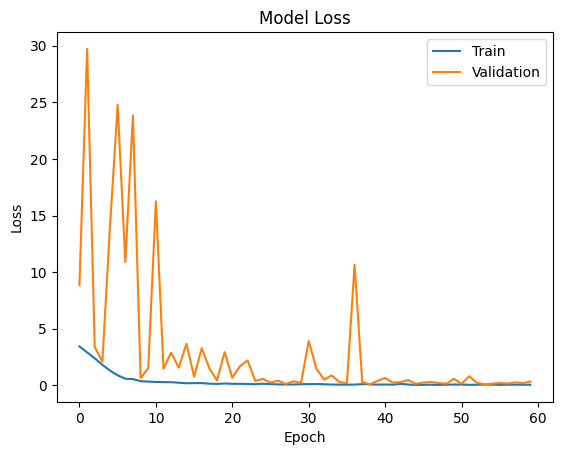

In [12]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

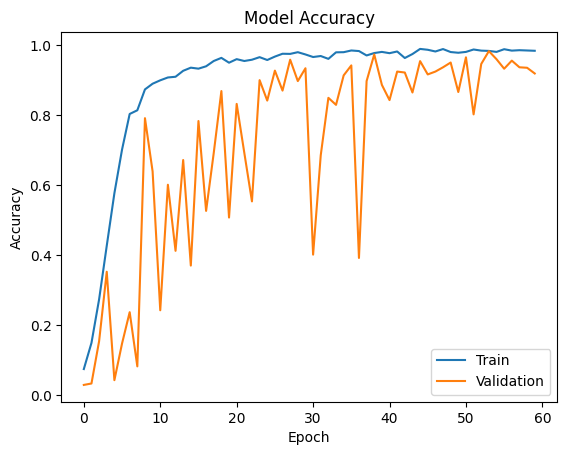

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

In [14]:
model.save_weights('res18_model.weights.h5')
# model.save('res18_full_model.h5')

In [15]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

loaded_model = model

test_data_dir = '/kaggle/working/new_data/test'
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224,224),  
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False  
)

predictions = loaded_model.predict(test_generator)

true_labels = test_generator.classes

predicted_labels = np.argmax(predictions, axis=1)

class_names = list(test_generator.class_indices.keys())
print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=class_names))

Found 24118 images belonging to 29 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


754/754 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step
Classification Report:
               precision    recall  f1-score   support

           A       0.99      0.99      0.99       823
           B       1.00      0.98      0.99       830
           C       1.00      1.00      1.00       839
           D       1.00      1.00      1.00       830
           E       0.97      0.91      0.94       830
           F       1.00      0.99      0.99       833
           G       1.00      0.99      0.99       819
           H       1.00      1.00      1.00       837
           I       1.00      1.00      1.00       831
           J       1.00      0.94      0.97       838
           K       1.00      0.70      0.82       823
           L       1.00      1.00      1.00       824
           M       0.95      0.98      0.96       838
           N       1.00      0.94      0.97       829
           O       0.99      0.99      0.99       834
           P       0.97      1.00      0.98       835
           Q  

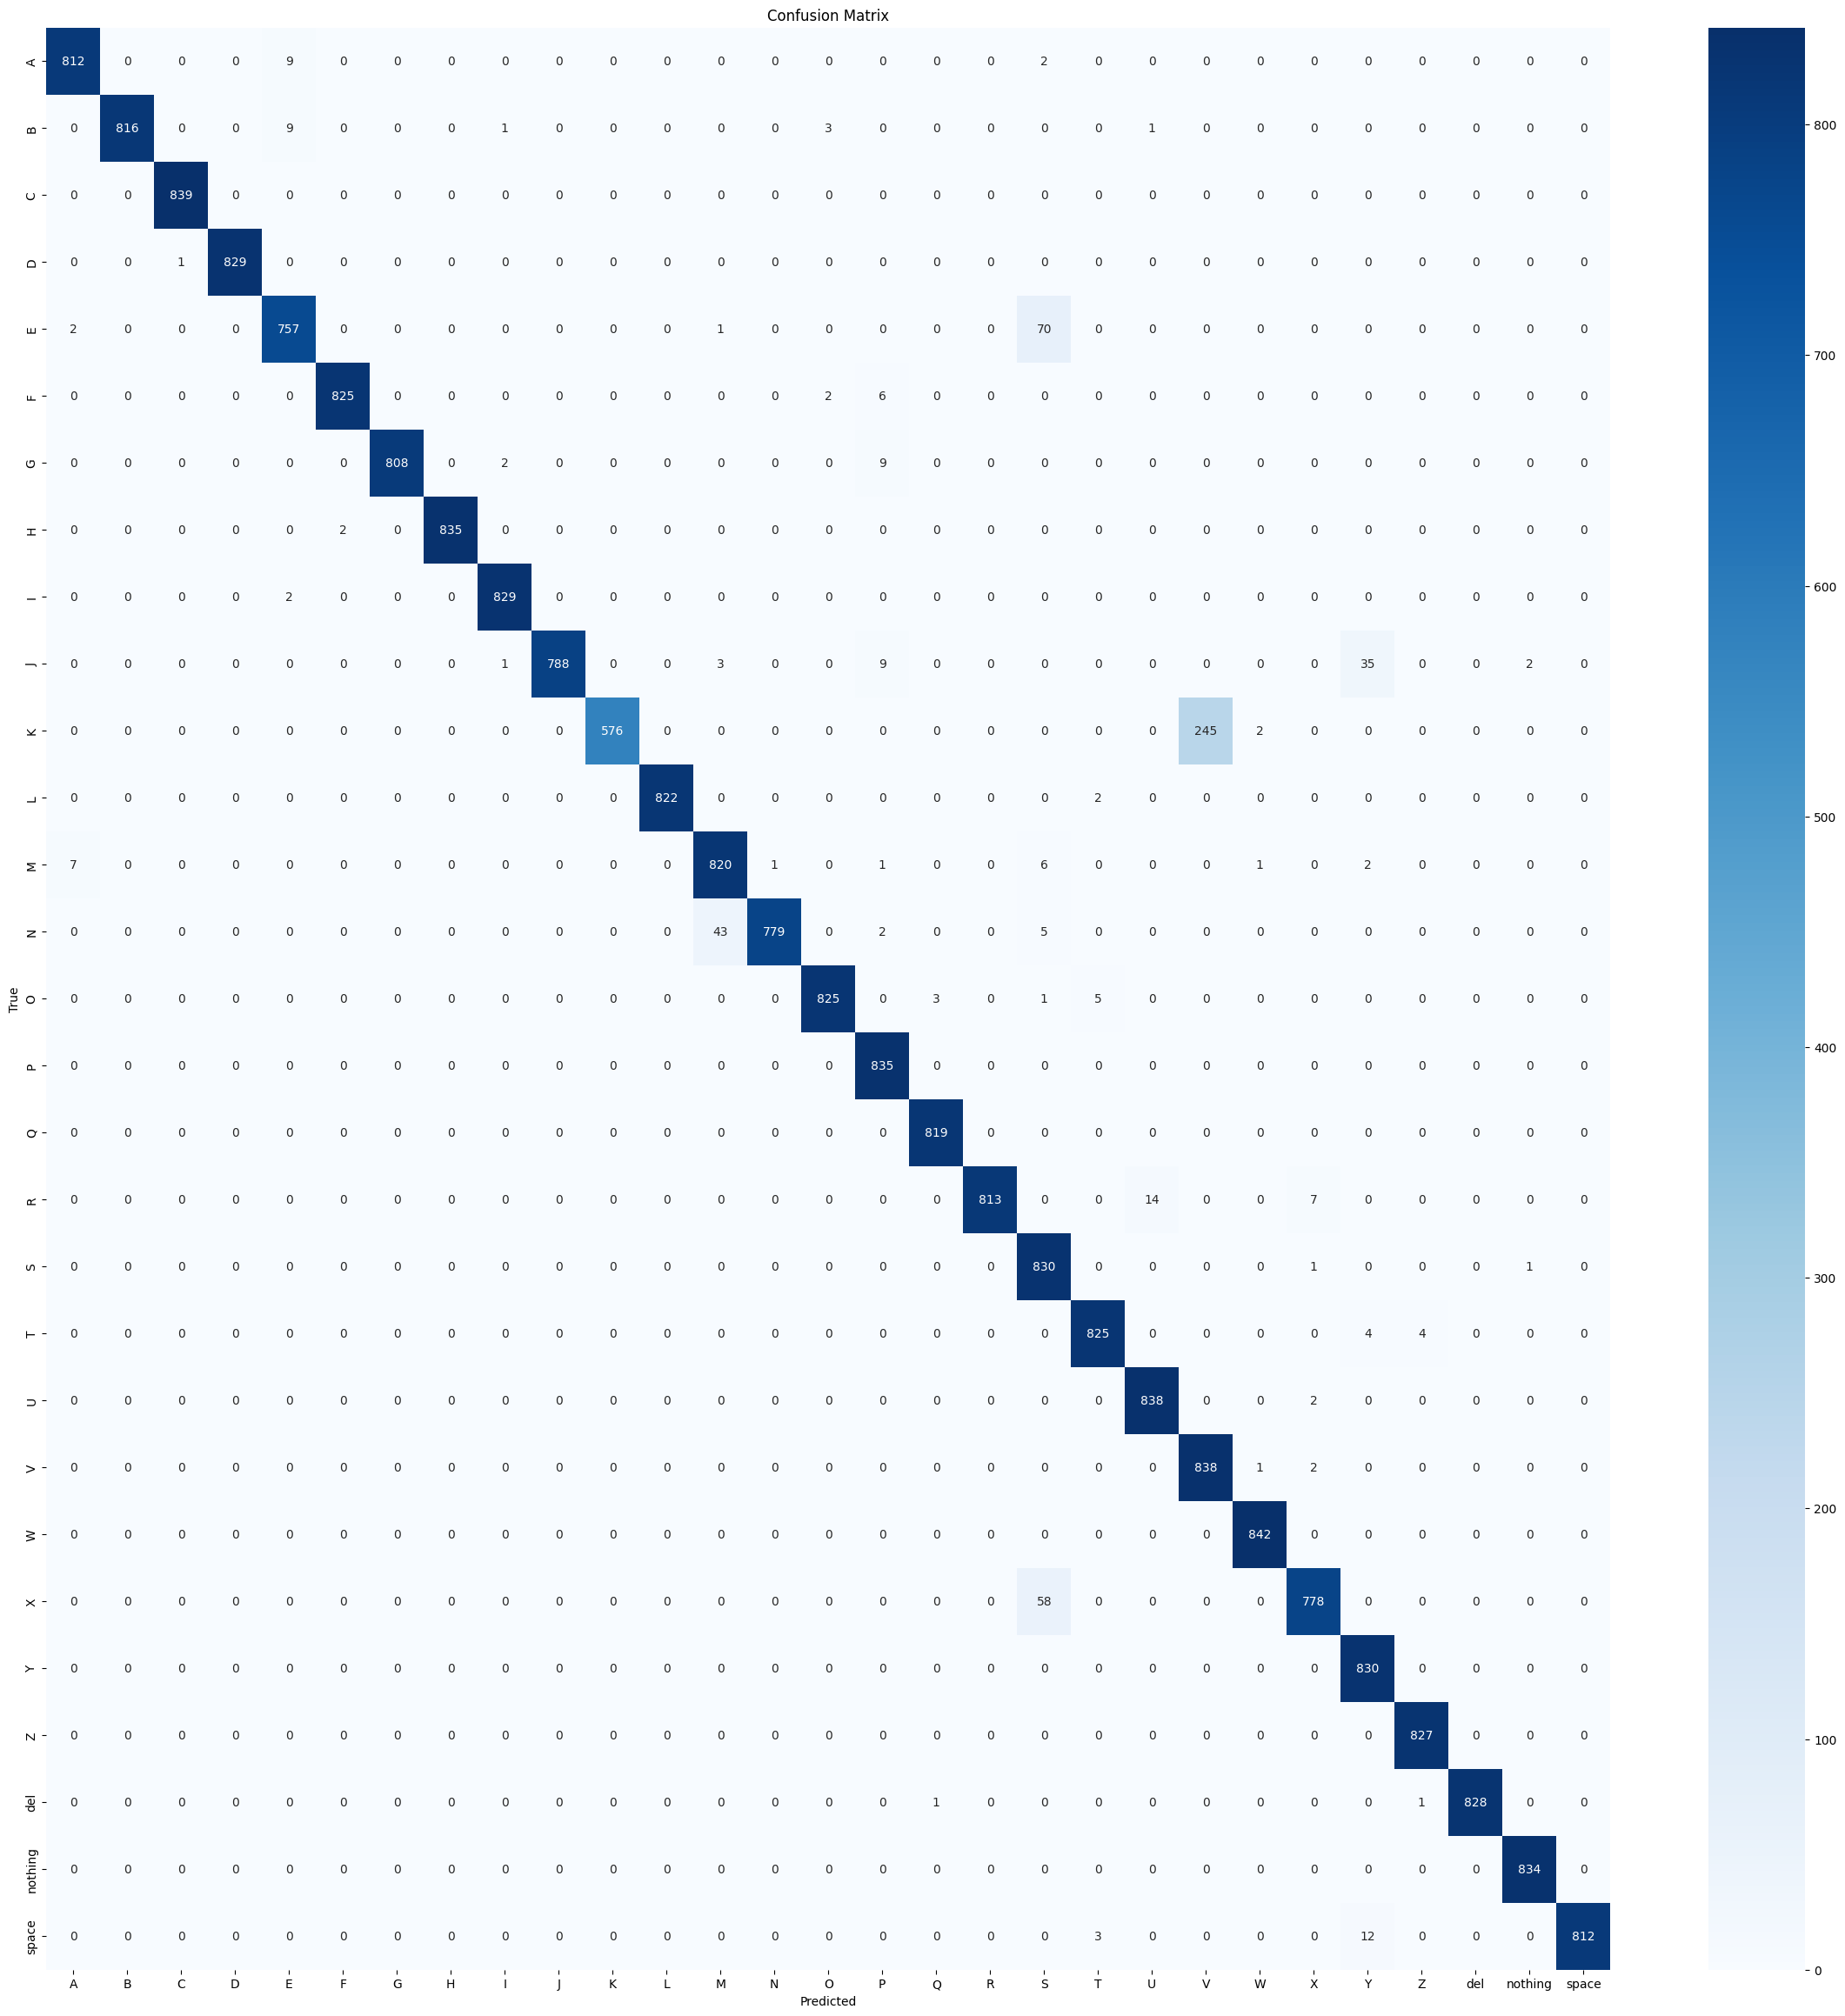

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(len(class_names), len(class_names)))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()